In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import cv2
from imageio import imread
import os

In [2]:
# To not use imageio to read the images, you can use:
# img_ = cv2.imread('../variational-approach/uq-vae/DAS/all-images/im0001.ppm', cv2.IMREAD_COLOR)
# img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

## Imports

# Load dataset

In [3]:
dataset = []
img = imread('../variational-approach/uq-vae/DAS/all-images/im0001.ppm')  # keep green channel as they do in https://www.hindawi.com/journals/ijbi/2013/154860/#B3
print(img.shape)
print('Getting rid of last 5 pixels to have 600x700 images')

dataset = np.empty(shape=(403, 600, 700)) # Remove the colour channel; add it just before training
for dirname, _, filenames in os.walk('../variational-approach/uq-vae/DAS/all-images'):
    for i, filename in enumerate(filenames):
        path = os.path.join(dirname, filename).replace("\\", "/")
        img = imread(path)[:,:,1]  # keep only green channel as in the paper
        dataset[i, :, :] = img[0:600, :]
print(dataset.shape)

(605, 700, 3)
Getting rid of last 5 pixels to have 600x700 images
(403, 600, 700)


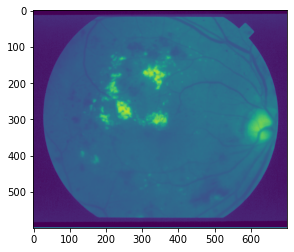

In [4]:
line = np.zeros(dataset[109,:,:].shape)
line[599,:] = 255
plt.imshow(dataset[94,:,:] + line)#*np.random.random(dataset[109,:,:,0].shape)*100)

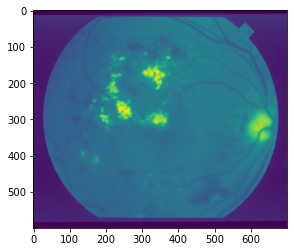

In [5]:
plt.imshow(dataset[94,0:600,:])

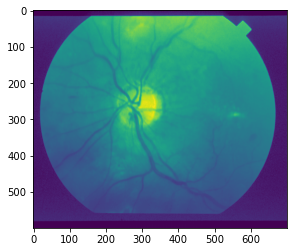

In [6]:
plt.imshow(dataset[200,:,:])

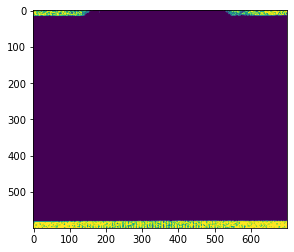

In [7]:
plt.imshow(dataset[200,:,:] == 0)

In [8]:
sum(sum(dataset[200,:,:] == 0))

15599

## Data Simulation Steps

In [9]:
grid_size = 130
matriz_size_in_GB = grid_size**4 * 10e-9
matriz_size_in_GB

2.8561

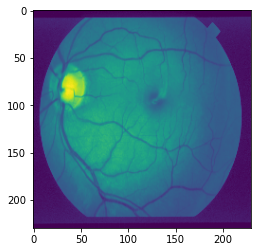

In [10]:
img = dataset[230,:,:]
bilinear_img = cv2.resize(img, dsize=(230,230), interpolation = cv2.INTER_LINEAR)
plt.imshow(bilinear_img)

### Implementation

#### Rotate 10°

In [11]:
def rotate_from_center(image, degrees):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=(cX, cY), angle=degrees, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

N, h, w = dataset.shape
degree_step = 10 #ideally, 10
degrees = range(10, 360, degree_step)  #steps of degree_step
N_new = N * len(degrees)
array_img = np.zeros((N_new,h,w))
for i, deg in enumerate(degrees):
    for n in range(N):
        array_img[i*N+n-1,:,:] = rotate_from_center(dataset[n,:,:,:], deg).reshape((1,h,w))
dataset = np.append(dataset, array_img, axis=0)

MemoryError: Unable to allocate 44.1 GiB for an array with shape (14105, 600, 700) and data type float64

#### Crop images down

In [123]:
np.append(np.zeros((0,h,w)), np.zeros((0,h,w)), axis=0).shape

(0, 605, 700)

In [ ]:
def get_crops(image, size=(600,600)):
    """Do it in strides of 10 along the width axis (being images h x w).
        * size: will be the dimension of the output array like:
            (number_of_imgs_at_the_end, size[0], size[1])
    """
    strides_of = 10
    array_img = np.zeros((size[0],size[1]))
    for i in range(10):
        cropped = image[:,i*strides_of:600+i*strides_of]
        array_img = np.append(array_img, cropped, axis=0)
    return array_img.reshape((-1,600,600))

aux = get_crops(dataset[0,:,:])
N = dataset.shape[0]
final_array_img = np.zeros((0,600,600))
for i in range(N):
    array_img = get_crops(dataset[i,:,:])
    final_array_img = np.append(final_array_img, array_img, axis=0)
dataset = final_array_img

In [ ]:
dataset.shape

In [ ]:
2- crop the 605x700 images of fundus using sliding window of 600x600
3- interpolate to 230x230 (k-Wave grid shape) --> maybe use 130x130 due to the memory problem of the matrix (item 8 below)
4- scale to max val of 1

In [119]:
array_img.shape
np.append(dataset, array_img, axis=0).shape

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [99]:
rot = rotate_from_center(dataset[n,:,:,:], deg).reshape((1,h,w,c))
array_img[0,:,:,:] = rot

In [73]:
aux_set = dataset[0:2,:,:,:]
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center=(cX, cY), angle=60, scale=1.0)
aux_set[]

In [77]:
M = cv2.getRotationMatrix2D(center=(cX, cY), angle=60, scale=1.0)
def applyRotationMatrix(arr):
    return cv2.warpAffine(image, M, (w, h))
np.apply_over_axes(applyRotationMatrix, aux_set, axes=(1,2,3))

TypeError: applyRotationMatrix() takes 1 positional argument but 2 were given

## Inverse problem